In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.linalg import svd
from functions import *
from get_estimated_covariance import *
import scipy.stats
from scipy.interpolate import UnivariateSpline
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


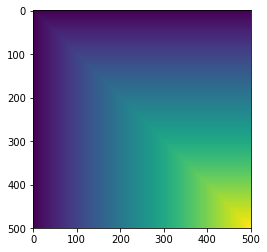

In [2]:
n = 500
t = np.linspace(0,1,n+1)
ma = np.meshgrid(t,t)
#bla = np.exp(-(ma[0]-ma[1])**2/0.01)
A = np.minimum(ma[0],ma[1])
A = A[1:,1:]
plt.imshow(A)

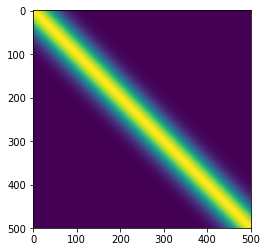

In [3]:
n = 500
t = np.linspace(0,1,n)
ma = np.meshgrid(t,t)
A = np.exp(-(ma[0]-ma[1])**2/0.01)
#A = np.minimum(ma[0],ma[1])
#A = A[1:,1:]
plt.imshow(A)

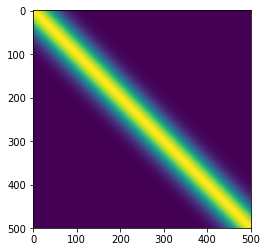

In [4]:
n = 500
t = np.linspace(0,1,n)
ma = np.meshgrid(t,t)
A = np.exp(-(ma[0]-ma[1])**2/0.01)
plt.imshow(A)

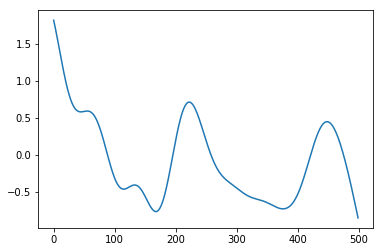

In [5]:
x = np.random.multivariate_normal(np.zeros(n), A)
plt.plot(x)

In [61]:
eigv, eigf = np.linalg.eigh(A)

In [62]:
np.linalg.matrix_rank(A)

41

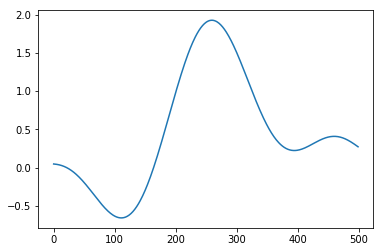

In [63]:
r = 5
rA = eigf[:,-r:] @ np.diag(eigv[-r:]) @ eigf[:,-r:].T
sqrtrA = eigf[:,-r:] @ np.diag(np.sqrt(eigv[-r:])) @ eigf[:,-r:].T
plt.plot(np.random.multivariate_normal(np.zeros(n), rA))

noise = (np.random.normal(0,1,n)/np.arange(500,500+n))**2
noisyrA = rA + eigf @ np.diag(noise) @ eigf.T
plt.plot(np.random.multivariate_normal(np.zeros(n), noisyrA))

/home/william/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in sqrt


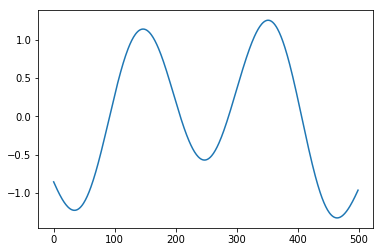

In [64]:
newdiag = np.copy(eigv)
newdiag[:-r] /= 1000
noisyrA = eigf @ np.diag(newdiag) @ eigf.T
noisysqrtrA = eigf @ np.diag(np.sqrt(newdiag)) @ eigf.T
plt.plot(np.random.multivariate_normal(np.zeros(n), noisyrA))

In [65]:
np.linalg.matrix_rank(rA),np.linalg.matrix_rank(noisyrA)

(5, 35)

In [92]:
U = np.zeros((n,r+1))
for i in range(r+1):
    U[:,i] = np.sqrt(2) * np.sin((i+1)*np.pi*t)
diag = np.array([1/(i+1)**2 for i in range(r+1)])
diag[-1] = 1e-4
diag = np.diag(diag)
A = U @ diag @ U.T

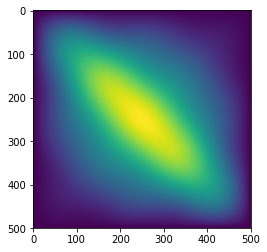

In [93]:
plt.imshow(A)

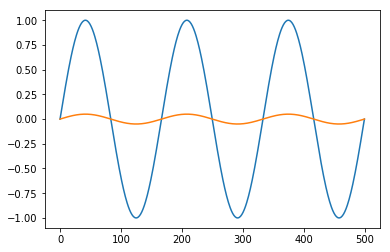

In [104]:
ormu = np.sin(6 * np.pi * t)
t = np.linspace(0,1,n)
plt.plot(ormu)
plt.plot(A @ ormu )

In [105]:
np.linalg.norm(ormu),np.linalg.norm(np.linalg.pinv(A) @ ormu)

(15.795568998931316, 316.54446891645733)

In [619]:
def genrv(scov,N):
    x = np.random.multivariate_normal(np.zeros(n),np.eye(n),N)
    return x @ scov 

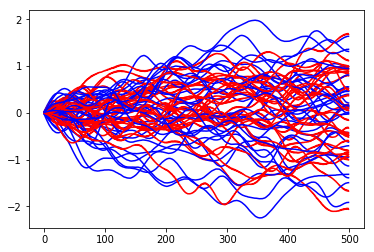

In [620]:
for i in range(30):
    plt.plot(genrv(noisysqrtrA,1)[0]+ormu,'r') 
    plt.plot(genrv(noisysqrtrA,1)[0],'b')

In [621]:
N = 5000
data1 = genrv(scipy.linalg.sqrtm(A),N)
data2 = genrv(scipy.linalg.sqrtm(A),N) + ormu

In [622]:
alpha = 1e-5
regrA = rA + alpha * np.eye(n)

In [623]:
disc = np.linalg.solve(A,ormu)

In [624]:
def disctest(x,mu):
    return (disc @ x)**2 - (disc @ (x-mu))**2

In [625]:
res = np.zeros((N,2))
for _ in range(N):
    res[_] = np.array([disctest(data1[_],ormu),disctest(data2[_],ormu)])

{'boxes': [<matplotlib.lines.Line2D at 0x7f2a3666cd68>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2a366718d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f2a36678630>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f2a366781d0>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f2a3666cef0>,
  <matplotlib.lines.Line2D at 0x7f2a3667c390>]}

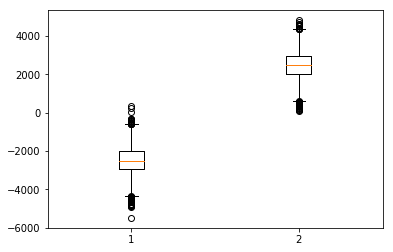

In [626]:
plt.boxplot(res)

In [627]:
np.mean(res[:,0]<0),np.mean(res[:,1]>0)

(0.99939999999999996, 1.0)

In [633]:
dt = 200
discfrags = np.zeros((n-dt,dt))
for i in range(n-dt):
    cov = A[i:i+dt,i:i+dt]
    discfrags[i] = np.linalg.solve(cov,ormu[i:i+dt])

In [634]:
def disctestfrag(x,mu,i):
    return (discfrags[i]@ x)**2 - (discfrags[i] @ (x-mu))**2

In [635]:
res = np.zeros((N*(n-dt),2))
for _ in range(N):
    for i in range(n-dt):
        res[_*(n-dt) + i] = np.array([disctestfrag(data1[_,i:i+dt],ormu[i:i+dt],i),disctestfrag(data2[_,i:i+dt],ormu[i:i+dt],i)])

{'boxes': [<matplotlib.lines.Line2D at 0x7f2a36587898>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2a3658d400>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f2a36592160>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f2a3658dcc0>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f2a36587a20>,
  <matplotlib.lines.Line2D at 0x7f2a36592e80>]}

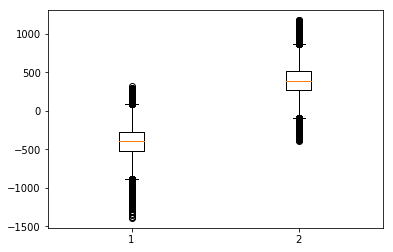

In [636]:
plt.boxplot(res)

In [637]:
np.mean(res[:,0]<0),np.mean(res[:,1]>0)

(0.98580933333333332, 0.985954)

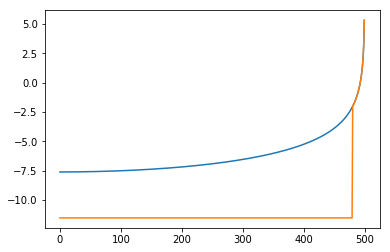

In [535]:
plt.plot(np.log(np.linalg.eigvalsh(A)))
plt.plot(np.log(np.linalg.eigvalsh(regrA)))

In [384]:
N = 5000
data1 = genrv(scipy.linalg.sqrtm(A),N)
data2 = genrv(scipy.linalg.sqrtm(A),N) + ormu

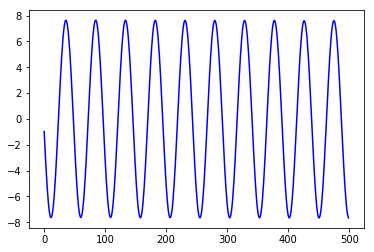

In [385]:
mu1 = data1.mean(0)
mu2 = data2.mean(0)
estmu = mu2-mu1
plt.plot(estmu,'b')

In [386]:
estmu = ormu

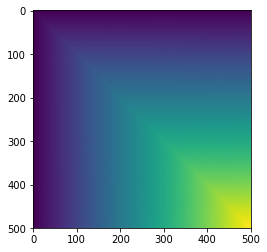

In [415]:
estcov = np.cov(np.r_[data1,data2-estmu], rowvar=False)
plt.imshow(estcov)

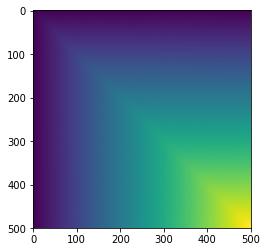

In [416]:
alpha = 0
regestcov = estcov + alpha * np.eye(n)
esteig = np.linalg.eigh(estcov)[1][:,-r:]
regestcov = esteig @ np.linalg.pinv(esteig.T @ esteig) @ esteig.T @ estcov
plt.imshow(regestcov)

In [417]:
disc = np.linalg.solve(regestcov,estmu)

In [418]:
def disctest(x,mu):
    return (disc @ x)**2 - (disc @ (x-mu))**2

In [419]:
res = np.zeros((N,2))
for _ in range(N):
    res[_] = np.array([disctest(data1[_],estmu),disctest(data2[_],estmu)])

{'boxes': [<matplotlib.lines.Line2D at 0x7f2a374c2358>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2a374c2e80>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f2a374c9be0>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f2a374c9780>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f2a374c24e0>,
  <matplotlib.lines.Line2D at 0x7f2a374ce940>]}

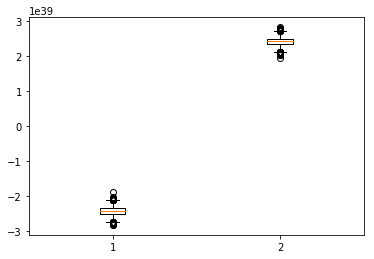

In [420]:
plt.boxplot(res)

In [421]:
np.mean(res[:,0]<0),np.mean(res[:,1]>0)

(1.0, 1.0)

In [438]:
dt = 20
discfrags = np.zeros((n-dt,dt))
for i in range(n-dt):
    cov = regestcov[i:i+dt,i:i+dt]
    discfrags[i] = np.linalg.solve(cov,estmu[i:i+dt])

In [439]:
def disctestfrag(x,mu,i):
    return (discfrags[i]@ x)**2 - (discfrags[i] @ (x-mu))**2

In [440]:
res = np.zeros((N*(n-dt),2))
for _ in range(N):
    for i in range(n-dt):
        res[_*(n-dt) + i] = np.array([disctestfrag(data1[_,i:i+dt],estmu[i:i+dt],i),disctestfrag(data2[_,i:i+dt],estmu[i:i+dt],i)])

{'boxes': [<matplotlib.lines.Line2D at 0x7f2a373ea780>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2a373f12e8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f2a373f6048>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f2a373f1ba8>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f2a373ea908>,
  <matplotlib.lines.Line2D at 0x7f2a373f6d68>]}

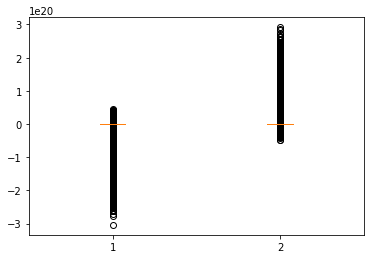

In [441]:
plt.boxplot(res)

In [442]:
np.mean(res[:,0]<0),np.mean(res[:,1]>0)

(0.87533208333333334, 0.87538583333333331)

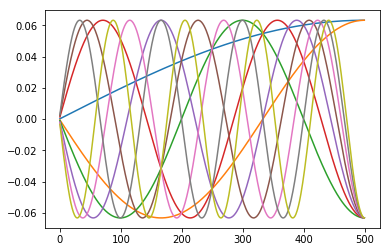

In [453]:
for _ in range(1,10):
    plt.plot(eigf[:,-_])

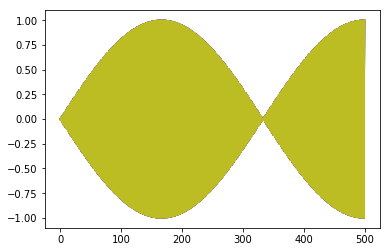

In [456]:
for _ in range(1,10):
    t = np.linspace(0,1,n)
    plt.plot(np.sin((501-0.5)*np.pi*t))

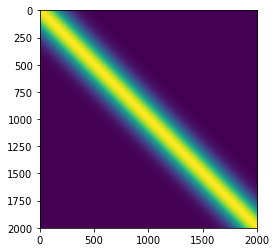

In [45]:
n = 2000
t = np.linspace(0,1,n)
ma = np.meshgrid(t,t)
A = np.exp(-(ma[0]-ma[1])**2/0.01) 
plt.imshow(A)

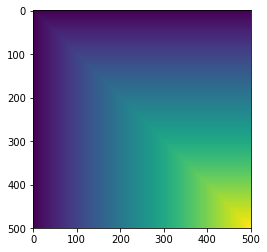

In [647]:
n = 500
t = np.linspace(0,1,n+1)
ma = np.meshgrid(t,t)
#bla = np.exp(-(ma[0]-ma[1])**2/0.01)
A = np.minimum(ma[0],ma[1])
A = A[1:,1:]
plt.imshow(A)

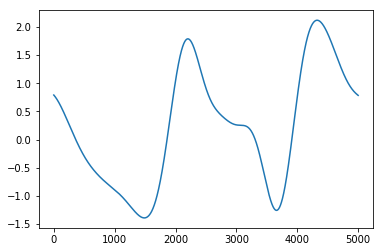

In [37]:
x = np.random.multivariate_normal(np.zeros(n), A)
plt.plot(x)

In [46]:
eigv, eigf = np.linalg.eigh(A)

In [47]:
np.linalg.matrix_rank(A)

40

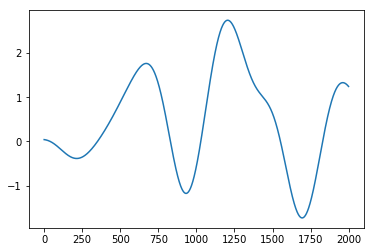

In [48]:
r = 20
rA = eigf[:,-r:] @ np.diag(eigv[-r:]) @ eigf[:,-r:].T
sqrtrA = eigf[:,-r:] @ np.diag(np.sqrt(eigv[-r:])) @ eigf[:,-r:].T
plt.plot(np.random.multivariate_normal(np.zeros(n), rA))

In [49]:
np.linalg.matrix_rank(rA)

20

In [52]:
mu = np.ones(n)/np.sqrt(n)

In [53]:
np.linalg.norm(np.linalg.pinv(scipy.linalg.sqrtm(rA))@ mu)

318656.64703425003

wesh = []
for dt in range(10,510,50):
    print(dt)
    for i in range(n-dt):
        ans = R.cdf(np.linalg.norm(np.linalg.pinv(scipy.linalg.sqrtm(rA[i:i+dt,i:i+dt]))@ mu[i:i+dt])/2)
        wesh.append(ans)
        if ans==1:
            print(dt,i)

In [54]:
R = scipy.stats.norm()
i=0
dt=500
R.cdf(np.linalg.norm(np.linalg.pinv(scipy.linalg.sqrtm(rA[i:i+dt,i:i+dt]))@ mu[i:i+dt])/2)

1.0

ind = 0
for dt in range(10,510,50):
    plt.plot(wesh[ind:ind+(n-dt)])
    plt.show()
    ind += n-dt

In [55]:
np.linalg.matrix_rank(np.c_[rA,mu])

21

In [63]:
wesh = []
for delta in range(1,50,1):
    print(delta)
    for i in range(n-delta):
        wesh.append(np.linalg.matrix_rank(np.c_[A[i:i+delta,i:i+delta],mu[i:i+delta]])-np.linalg.matrix_rank(A[i:i+delta,i:i+delta]))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


1


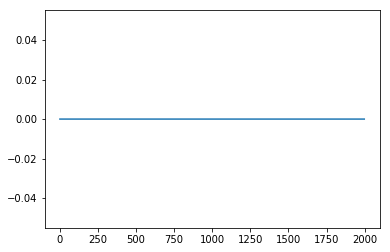

2


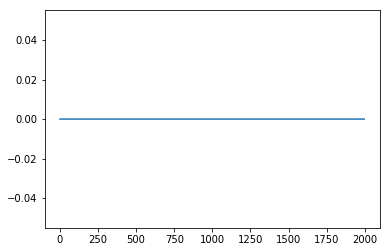

3


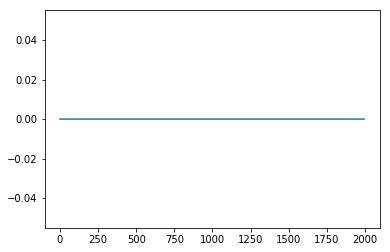

4


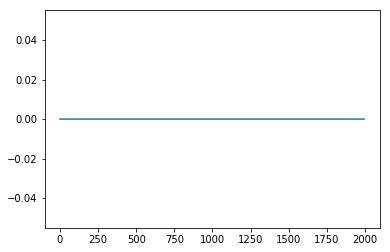

5


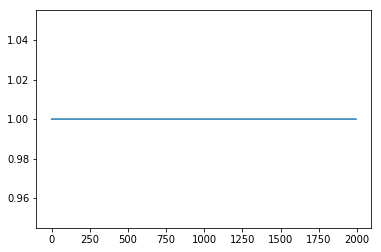

6


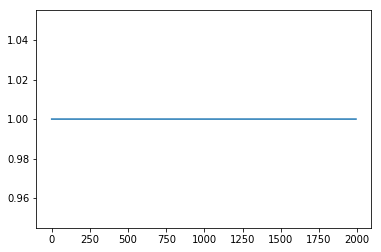

7


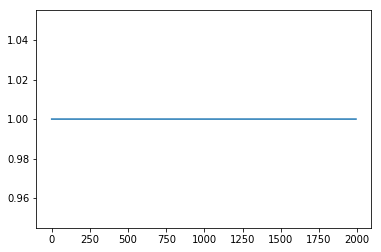

8


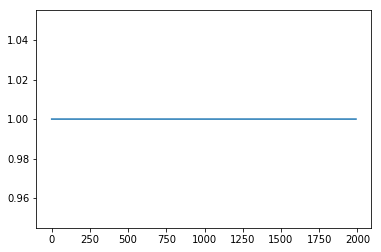

9


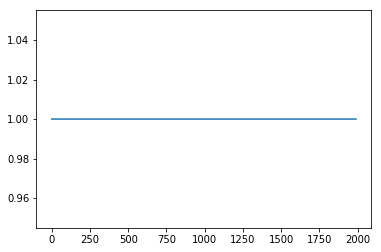

10


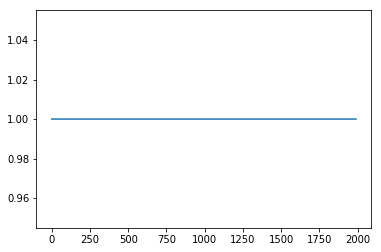

11


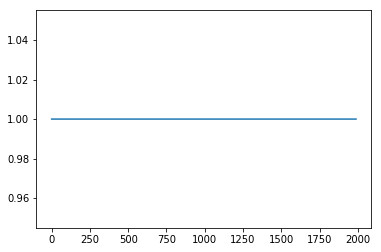

12


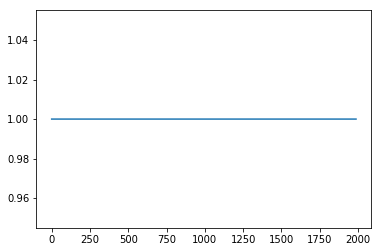

13


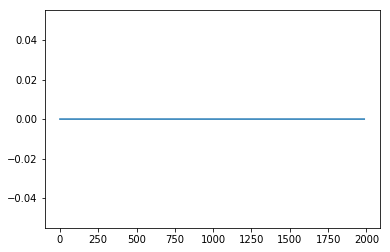

14


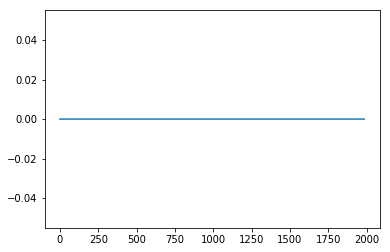

15


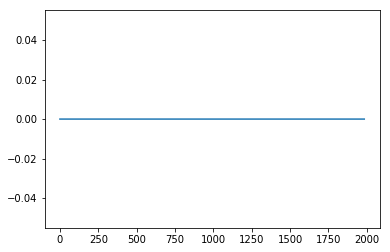

16


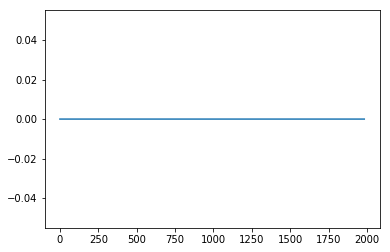

17


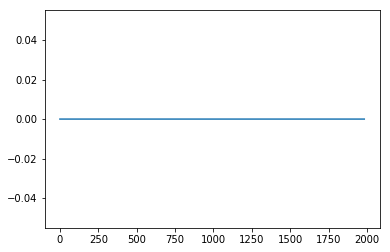

18


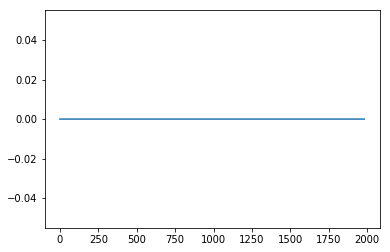

19


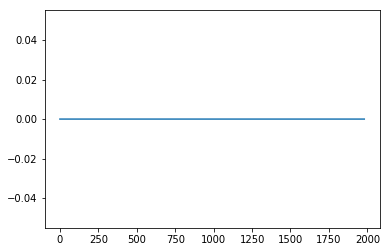

20


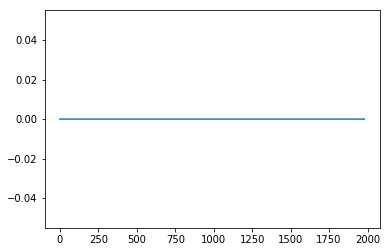

21


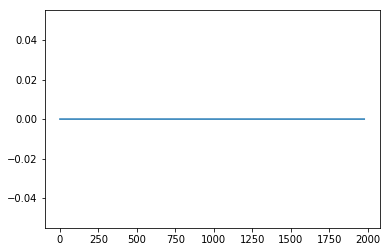

22


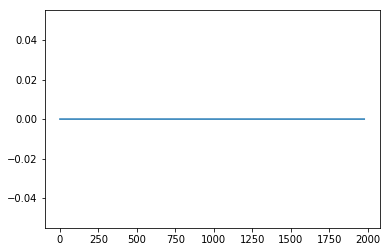

23


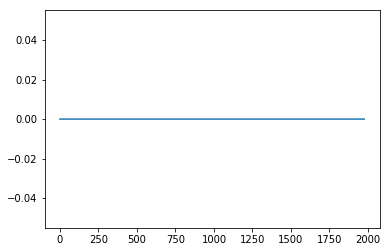

24


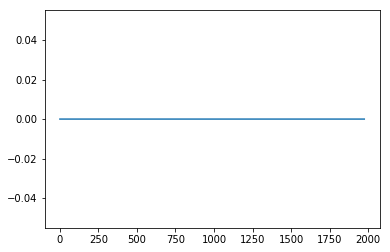

25


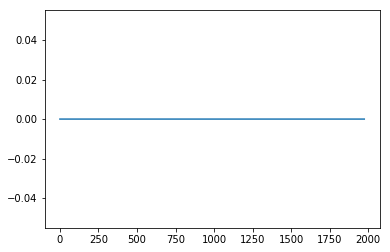

26


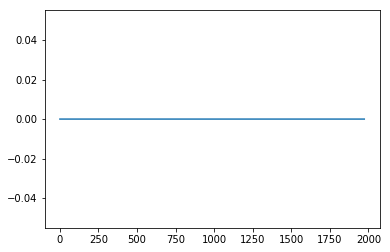

27


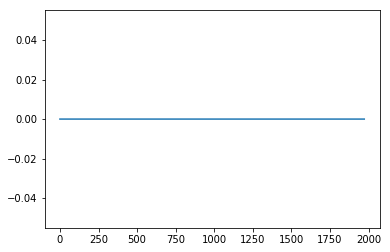

28


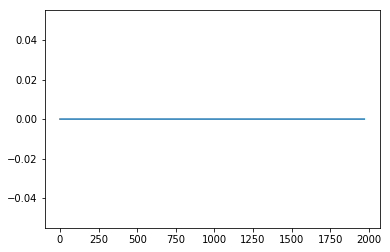

29


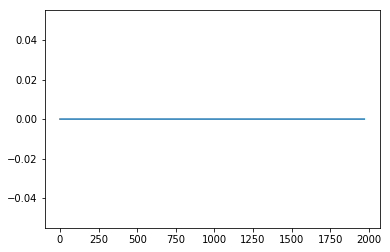

30


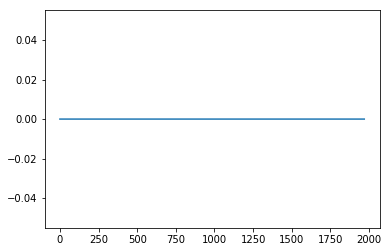

31


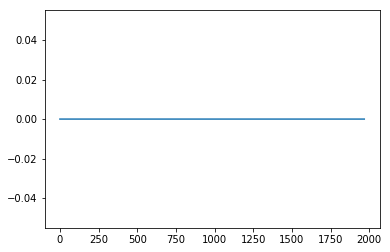

32


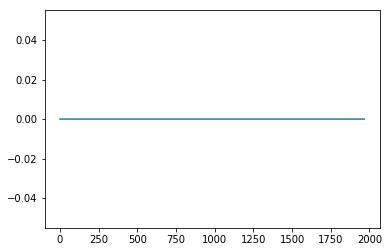

33


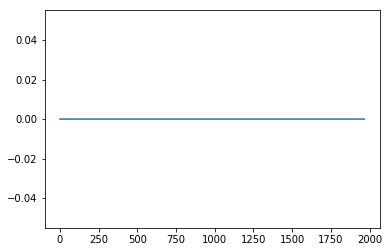

34


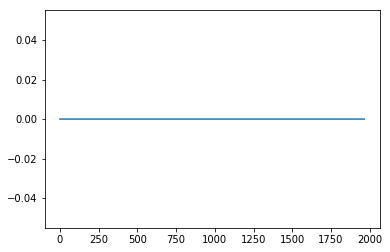

35


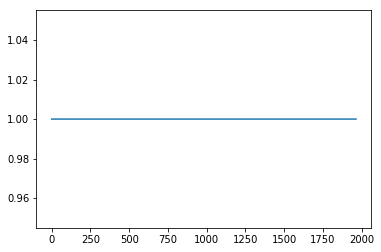

36


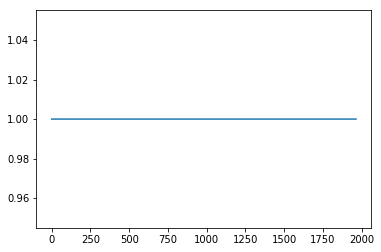

37


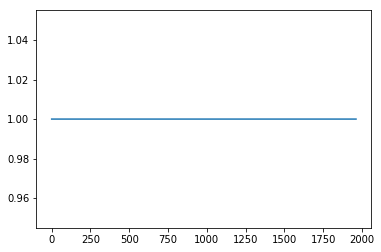

38


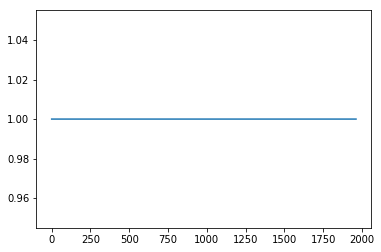

39


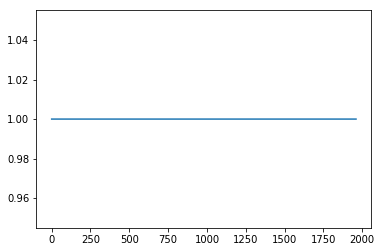

40


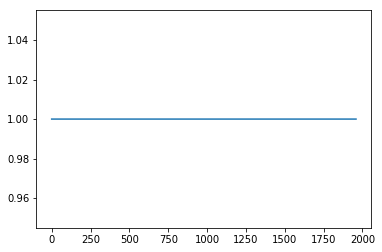

41


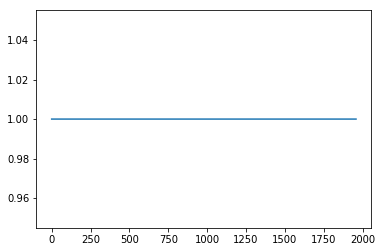

42


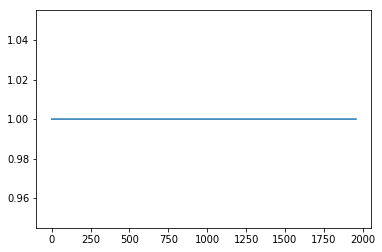

43


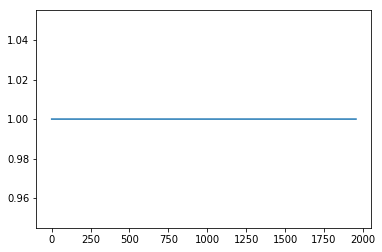

44


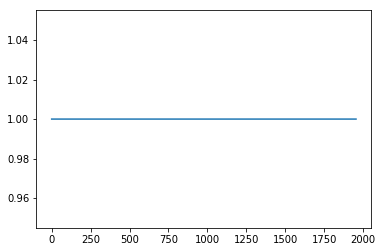

45


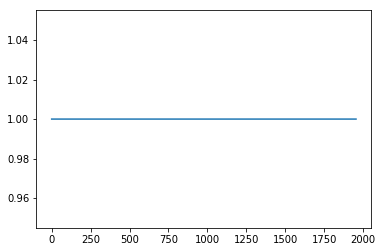

46


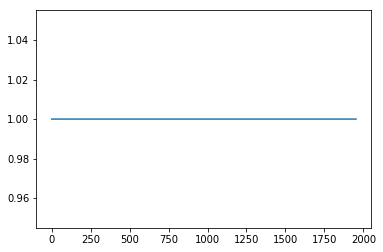

47


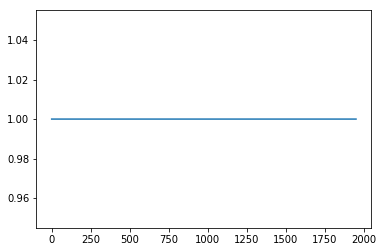

48


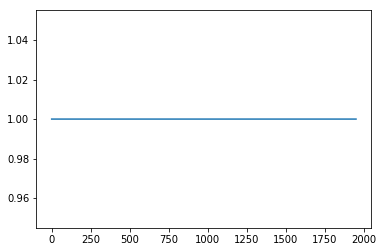

49


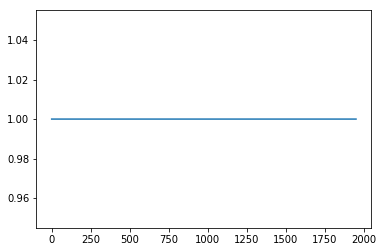

In [64]:
ind = 0
rec = {}
for dt in range(1,50,1):
    print(dt)
    plt.plot(wesh[ind:ind+(n-dt)])
    plt.show()
    rec[dt] = wesh[ind:ind+(n-dt)]
    ind += n-dt

In [65]:
for dt in range(1,50,1):
    print(dt, np.mean(rec[dt]))

1 0.0
2 0.0
3 0.0
4 0.0
5 1.0
6 1.0
7 1.0
8 1.0
9 1.0
10 1.0
11 1.0
12 1.0
13 0.0
14 0.0
15 0.0
16 0.0
17 0.0
18 0.0
19 0.0
20 0.0
21 0.0
22 0.0
23 0.0
24 0.0
25 0.0
26 0.0
27 0.0
28 0.0
29 0.0
30 0.0
31 0.0
32 0.0
33 0.0
34 0.0
35 1.0
36 1.0
37 1.0
38 1.0
39 1.0
40 1.0
41 1.0
42 1.0
43 1.0
44 1.0
45 1.0
46 1.0
47 1.0
48 1.0
49 1.0


In [115]:
U = np.zeros((n,r+1))
for i in range(r+1):
    U[:,i] = np.sqrt(2) * np.sin((i+1)*np.pi*t)
diag = np.array([1/(i+1)**2 for i in range(r+1)])
diag[-1] = 1e-4
diag = np.diag(diag)
A = U @ diag @ U.T

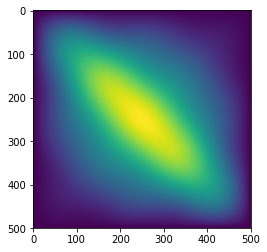

In [116]:
plt.imshow(A)

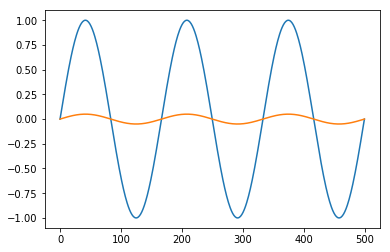

In [117]:
mu = np.sin(6 * np.pi * t)
t = np.linspace(0,1,n)
plt.plot(mu)
plt.plot(A @ mu )

In [120]:
np.linalg.norm(ormu),np.linalg.norm(np.linalg.pinv(A) @ mu)

(15.795568998931316, 316.54446891645733)

In [132]:
N = 1000
data1 = np.random.multivariate_normal(np.zeros(500),A,N)
data2 = np.random.multivariate_normal(mu,A,N)

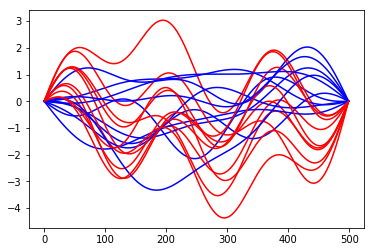

In [133]:
for i in range(10):
    plt.plot(data1[i],'b')
    plt.plot(data2[i],'r')

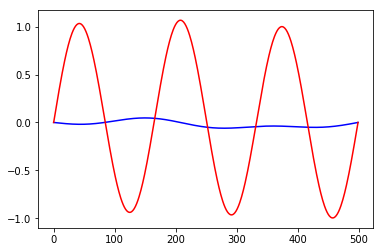

In [134]:
plt.plot(data1.mean(0),'b')
plt.plot(data2.mean(0),'r')

In [135]:
disc = np.linalg.pinv(A) @ mu

blaeigv = np.linalg.eigh(rA)[0]
blaeigf = np.linalg.eigh(rA)[1]

disc = np.zeros(500)
for i in range(1,r+1):
    disc += np.sum(blaeigf[:,-i]*mu)/500 * (1/blaeigv[-i]) *blaeigf[:,-i] 

plt.plot(disc)

In [136]:
def disctest(x,mu):
    return (disc @ x)**2 - (disc @ (x-mu))**2

In [137]:
res = np.zeros((N,2))
for _ in range(N):
    res[_] = np.array([disctest(data1[_],mu),disctest(data2[_],mu)])

{'boxes': [<matplotlib.lines.Line2D at 0x7f7cfcdc8828>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7cfcdce390>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f7cfcdd30f0>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f7cfcdcec50>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f7cfcdc89b0>,
  <matplotlib.lines.Line2D at 0x7f7cfcdd3e10>]}

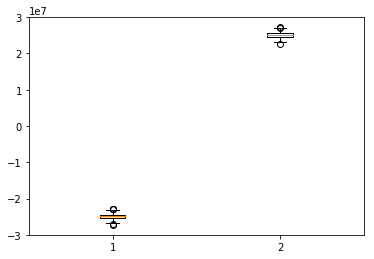

In [138]:
plt.boxplot(res)

In [139]:
np.mean(res[:,0]<0),np.mean(res[:,1]>0)

(1.0, 1.0)

In [140]:
np.mean([np.mean(res[:,0]<0),np.mean(res[:,1]>0)])

1.0

In [143]:
dt = 300
discfrags = np.zeros((n-dt,dt))
for i in range(n-dt):
    cov = A[i:i+dt,i:i+dt]
    discfrags[i] = np.linalg.pinv(cov) @ mu[i:i+dt]

In [144]:
np.linalg.matrix_rank(rA[:300,:300])

5

dt = 100
discfrags = np.zeros((n-dt,dt))
for i in range(n-dt):
    cov = rA[i:i+dt,i:i+dt]
    theeig = np.linalg.eigh(cov)
    blaeigv = theeig[0]
    blaeigf = theeig[1]

    for j in range(1,np.linalg.matrix_rank(cov)+1):
        discfrags[i] += np.sum(blaeigf[:,-j]*mu[i:i+dt])/dt * (1/blaeigv[-j]) *blaeigf[:,-j] 

In [146]:
def disctestfrag(x,mu,i):
    return (discfrags[i]@ x)**2 - (discfrags[i] @ (x-mu))**2

In [147]:
res = np.zeros((N*(n-dt),2))
for _ in range(N):
    for i in range(n-dt):
        res[_*(n-dt) + i] = np.array([disctestfrag(data1[_,i:i+dt],mu[i:i+dt],i),disctestfrag(data2[_,i:i+dt],mu[i:i+dt],i)])

{'boxes': [<matplotlib.lines.Line2D at 0x7f7cfce93390>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7cfce4e898>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f7cfce4a940>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f7cfce4a0b8>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f7cfce93588>,
  <matplotlib.lines.Line2D at 0x7f7cfce8d7f0>]}

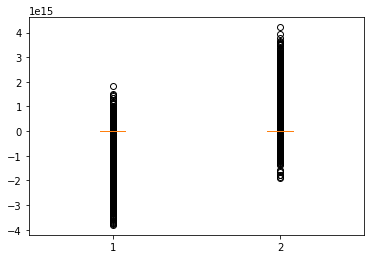

In [148]:
plt.boxplot(res)

In [149]:
np.mean(res[:,0]<0),np.mean(res[:,1]>0)

(0.95274000000000003, 0.95416500000000004)

In [724]:
np.mean([np.mean(res[:,0]<0),np.mean(res[:,1]>0)])

0.49678333333333335

In [789]:
dt=100
res = np.zeros((N,2))
for _ in range(N):
    i=0
    res[_] = np.array([disctestfrag(data1[_,i:i+dt],mu[i:i+dt],i),disctestfrag(data2[_,i:i+dt],mu[i:i+dt],i)])

In [790]:
np.mean(res[:,0]<0),np.mean(res[:,1]>0)

(1.0, 1.0)

In [727]:
for i in range(400):
    data1 = np.random.multivariate_normal(np.zeros(500),rA,N)
    data2 = np.random.multivariate_normal(mu,rA,N)
    dt=100
    res = np.zeros((N,2))
    for _ in range(N):
        res[_] = np.array([disctestfrag(data1[_,i:i+dt],mu[i:i+dt],i),disctestfrag(data2[_,i:i+dt],mu[i:i+dt],i)])
    print(np.mean(res[:,0]<0),np.mean(res[:,1]>0))

ValueError: shapes (260,) and (100,) not aligned: 260 (dim 0) != 100 (dim 0)

In [614]:
N=500
wesh = []
for dt in range(10,500,10):
    for maxrank in range(1,21,2):
        data1 = np.random.multivariate_normal(np.zeros(500),rA,N)
        data2 = np.random.multivariate_normal(mu,rA,N)
        discfrags = np.zeros((n-dt,dt))
        for i in range(n-dt):
            cov = rA[i:i+dt,i:i+dt]
            theeig = np.linalg.eigh(cov)
            blaeigv = theeig[0]
            blaeigf = theeig[1]

            #for j in range(1,np.linalg.matrix_rank(cov)+1):
            for j in range(1,min(maxrank,dt)+1):
                discfrags[i] += np.sum(blaeigf[:,-j]*mu[i:i+dt])/dt * (1/blaeigv[-j]) *blaeigf[:,-j] 

        def disctestfrag(x,mu,i):
            return (discfrags[i]@ x)**2 - (discfrags[i] @ (x-mu))**2

        res = np.zeros((N*(n-dt),2))
        for _ in range(N):
            for i in range(n-dt):
                res[_*(n-dt) + i] = np.array([disctestfrag(data1[_,i:i+dt],mu[i:i+dt],i),disctestfrag(data2[_,i:i+dt],mu[i:i+dt],i)])

        np.mean(res[:,0]<0),np.mean(res[:,1]>0)
        wesh.append(np.mean([np.mean(res[:,0]<0),np.mean(res[:,1]>0)]))
        print(maxrank,dt,np.mean([np.mean(res[:,0]<0),np.mean(res[:,1]>0)]))

1 10 0.502634693878
3 10 0.514467346939
5 10 0.52896122449
7 10 0.497157142857
9 10 0.508167346939
11 10 0.501483673469
13 10 0.510830612245
15 10 0.506593877551
17 10 0.503681632653
19 10 0.498779591837
1 20 0.505647916667
3 20 0.515033333333
5 20 0.5095875
7 20 0.511345833333
9 20 0.526795833333
11 20 0.507420833333
13 20 0.513735416667
15 20 0.514314583333
17 20 0.50403125


KeyboardInterrupt: 

In [354]:
wesha = np.array(wesh)
wesha = wesha.reshape((49,10))

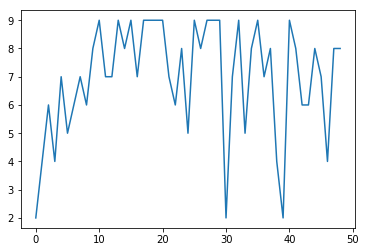

In [355]:
plt.plot(np.argmax(wesha,axis=1))

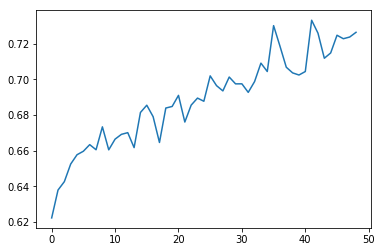

In [356]:
plt.plot(wesha.max(1))

In [357]:
np.argsort(wesha.max(1))

array([ 0,  1,  2,  3,  4,  5,  9,  7, 13,  6, 17, 10, 11, 12,  8, 21, 16,
       14, 18, 19, 15, 22, 24, 23, 20, 31, 27, 26, 29, 30, 32, 28, 25, 39,
       38, 40, 34, 37, 33, 43, 44, 36, 46, 47, 45, 42, 48, 35, 41])

In [358]:
wesha.max(1)[[45,32,34]]

array([ 0.72465   ,  0.69866471,  0.70431333])

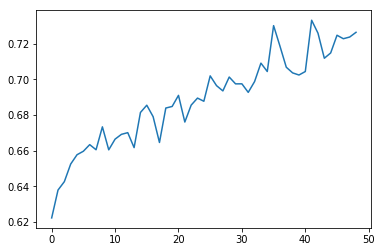

In [359]:
plt.plot(wesha.max(1))

In [118]:
xbig = np.linspace(0,1,500)**2
xsm = np.linspace(0,0.2,100)**2

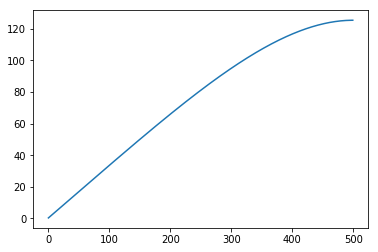

In [119]:
plt.plot(A @ xbig)

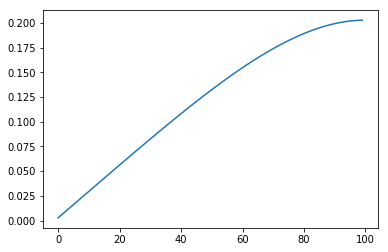

In [120]:
plt.plot(A[:100,:100] @ xsm)

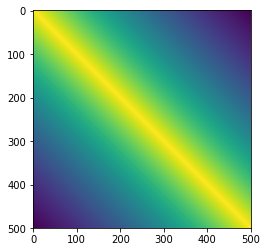

In [184]:
plt.imshow(A)

In [195]:
np.linalg.norm(np.linalg.solve(A,np.ones(500)))

0.70816841452843282

In [197]:
norms = []
for i in range(170):
    norms.append(np.linalg.norm(np.linalg.solve(A[i:i+330,i:i+330],np.ones(330))))

In [201]:
max(norms)

0.70804789485221775

In [189]:
R = scipy.stats.norm()

In [192]:
1-R.pdf(0.7/2)

0.62475965308306214

In [21]:
for n in range(100,5000,300):
    print('Size is ' + str(n))
    r = 10
    t = np.array([np.random.uniform(i/n,(i+1)/n) for i in range(n)])
    U = np.zeros((n,r+1))
    for i in range(r+1):
        U[:,i] = np.sqrt(2) * np.sin((i+1)*np.pi*t)
    diag = np.array([1/(i+1)**2 for i in range(r+1)])
    diag[-1] = 1e-4
    diag = np.diag(diag)
    A = U @ diag @ U.T


    mu = np.sin((r+1) * np.pi * t) * 1e-2

    #print(np.linalg.norm(mu),np.linalg.norm(np.linalg.pinv(A) @ mu))

    N = 1000
    #data1 = np.random.multivariate_normal(np.zeros(n),A,N)
    #data2 = np.random.multivariate_normal(mu,A,N)
    data1 = np.random.normal(0,1,(N,r+1)) @ np.sqrt(diag) @ U.T
    data2 = np.random.normal(0,1,(N,r+1)) @ np.sqrt(diag) @ U.T + mu
    disc = scipy.linalg.pinv(A) @ mu


    def disctest(x,mu):
        return (disc @ x)**2 - (disc @ (x-mu))**2

    res = np.zeros((N,2))
    for _ in range(N):
        res[_] = np.array([disctest(data1[_],mu),disctest(data2[_],mu)])


    #print(np.mean(res[:,0]<0),np.mean(res[:,1]>0))

    print(np.mean([np.mean(res[:,0]<0),np.mean(res[:,1]>0)]))

    dt = 0.5
    dt = int(n*dt)
    discfrags = np.zeros((n-dt,dt))
    for i in range(n-dt):
        cov = A[i:i+dt,i:i+dt]
        discfrags[i] = scipy.linalg.pinv(cov) @ mu[i:i+dt]


    def disctestfrag(x,mu,i):
        return (discfrags[i]@ x)**2 - (discfrags[i] @ (x-mu))**2

    #res = np.zeros((N*(n-dt),2))
    res = []
    for _ in range(N):
        for i in range(n-dt):
            #res[_*(n-dt) + i] = np.array([disctestfrag(data1[_,i:i+dt],mu[i:i+dt],i),disctestfrag(data2[_,i:i+dt],mu[i:i+dt],i)])
            res.append([disctestfrag(data1[_,i:i+dt],mu[i:i+dt],i),disctestfrag(data2[_,i:i+dt],mu[i:i+dt],i)])
    res = np.array(res)
    #print(np.mean(res[:,0]<0),np.mean(res[:,1]>0))

    print(np.mean([np.mean(res[:,0]<0),np.mean(res[:,1]>0)]))

    print('Done')

Size is 100
0.6125
0.61286
Done
Size is 400
0.637
0.63697
Done
Size is 700
0.635
0.634838571429
Done
Size is 1000
0.6225
0.622508
Done
Size is 1300
0.624
0.624
Done
Size is 1600
0.6345
0.6345
Done
Size is 1900
0.62
0.62
Done
Size is 2200
0.648
0.648
Done
Size is 2500
0.649
0.6489984
Done
Size is 2800
0.645


KeyboardInterrupt: 

In [ ]:
scipy.linalg.pinvh()

0.703562363974 71.0669054519
1.0 1.0
1.0
0
0.9508 0.945115789474
0.947957894737
Done
1.22270192606 40.8930410055
1.0 1.0
1.0
0
0.953136842105 0.951361403509
0.952249122807
Done
1.73060682999 28.8915998328
1.0 1.0
1.0
0.969656140351 0.967880701754
0.968768421053
Done
2.23494966386 22.3718685071
1.0 0.999
0.9995
0.97164 0.968518947368
0.970079473684
Done
2.54852898747 19.6199610116
1.0 1.0
1.0
0.973331983806 0.97276194332
0.973046963563
Done
2.82754310312 17.6831963922
1.0 1.0
1.0
0.970910526316 0.971876973684
0.97139375
Done
3.08139578763 16.2264127837
0.999 1.0
0.9995
0.971083102493 0.972587811634
0.971835457064
Done
3.31587092632 15.0808081468
0.999 1.0
0.9995
0.973610526316 0.970893779904
0.97225215311
Done
3.53482672843 14.1536425573
1.0 1.0
1.0
0.974027368421 0.972887157895
0.973457263158
Done
3.740989174 13.3782020926
1.0 1.0
1.0
0.973266541353 0.974083834586
0.97367518797
Done

In [5]:
n = 1000
r = 5
t = np.linspace(0,1,n)
U = np.zeros((n,r+1))
for i in range(r+1):
    U[:,i] = np.sqrt(2) * np.sin((i+1)*np.pi*t)
diag = np.array([1/(i+1)**2 for i in range(r+1)])
diag[-1] = 1e-4
diag = np.diag(diag)
A = U @ diag @ U.T
sA = U @ np.sqrt(diag) @ U.T


mu = np.sin((r+1) * np.pi * t) * 1e-1

print(np.linalg.norm(mu),np.linalg.norm(np.linalg.pinv(sA) @ mu))
dt = 0.05
dt = int(n*dt)
discfrags = np.zeros((n-dt,dt))
for i in range(n-dt):
    cov = A[i:i+dt,i:i+dt]
    scov = scipy.linalg.sqrtm(cov)
    print(np.linalg.norm(np.linalg.pinv(scov) @ mu[i:i+dt]))


2.23494966386 0.223765157338
Matrix is singular and may not have a square root.
5.66448250279
5.47934138274
90.5629828747
10.344375565
5.09159857682
4.8120794264
7.58309789999
5.70839900268
4.75936212715
4.9111285574
4.75956102041
9.03007620531
4.42038515988
5.85433833103
4.61903374065
5.36127643487
4.67667698313
4.98170233296
4.5945451285
4.73213780936
6.61758120303
4.38340309285
4.54649581696
4.46598627367
4.42339676269
4.49023231202
4.95910300327
4.49395682598
4.98225189125
6.05696181112
4.46317807571
4.75681004827
5.74154174116
4.46031028981
7.10954886823
7.79631609431
10.2100796301
5.04185335827
5.25419798364
4.83697187277
12.8430727617
7.32297768597
4.70608892869
7.0997513525
22.7322024757
18.5121291709
8.62685316677
5.78302967541
6.04749095695
9.35215472094
9.61047582949
8.89726315015
21.7318615795
8.81571345135
11.0664321008
8.88043045967
18.5704499232
14.4276164393
11.6434265466
15.962721266
17.916829954
14.1797172721
6.45309523014
11.3500582643
10.8596639176
16.2855291653
13.